## Project 1: Classifying ENSO


In [76]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## a)
#### Load in the data from the netcdf file. This is ERSSTv5 SST (sea surface temperature) data set which has been de-seasoned, linearly detrended, and has a 5 month look back running mean applied. See notebook.


The data is loaded as described and plotted below.

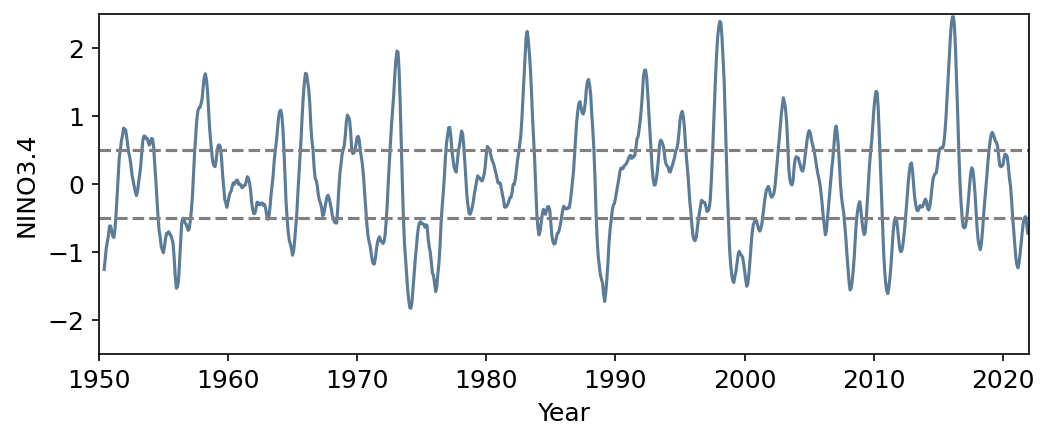

In [77]:
import os
import wget
url = 'https://webspace.science.uu.nl/~dijks101/ATCD/ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
filename = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
if not os.path.exists(filename):
    filename = wget.download(url)
sstds = xr.open_dataset(filename)
sst = sstds.sst
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))
timevec = np.arange(1950+(5/12),2022,1/12)

plt.figure(figsize=(8,3))
plt.plot(timevec,nino34,color='xkcd:slate blue')
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.xlabel("Year")
plt.ylabel("NINO3.4")
plt.show()

## b)
#### Include only samples where an El Niño or La Niña events is occurring (i.e. NINO3.4 > 0.5 or NINO3.4 < −0.5). Make two classes, where 1 is the occurrence of an El Niño and 0 is the occurrence of a La Niña. Then, divide the SST fields and NINO3.4 output into training (1950 − 2000) validation (e.g. years 2000 − 2010) and testing (> 2010) sets. Make a plot of the NINO3.4 data of the El Niño and La Niña events and show the different date sets (training, validation and testing) in different colours. Standardise the SST anomaly values of all selected data in b. using the standard deviation of each grid cell within the training set (and set all NaNs, i.e. landpoints, to zero).


First the data is filtered, divided and standardized and prepared as requested.


In [78]:
# Filter data to only include samples where an El Nino or La Nina event is occurring
mask = (nino34 > 0.5) | (nino34 < -0.5)
sst_filtered = np.asarray(sst)[mask]
nino34_filtered = nino34[mask]
timevec_filtered = timevec[mask]

# Divide data into training, validation, and testing sets

# Create splitting masks
train_mask = (timevec_filtered >= 1950) & (timevec_filtered < 2000)
val_mask = (timevec_filtered >= 2000) & (timevec_filtered <= 2010)
test_mask = timevec_filtered > 2010

# Create binary classes for El Nino and La Nina events
classes = np.where(nino34_filtered > 0.5, 1, 0)
classes_train = classes[train_mask]
classes_val = classes[val_mask]
classes_test = classes[test_mask]

# Slit SST data
sst_train = sst_filtered[train_mask]
sst_val = sst_filtered[val_mask]
sst_test = sst_filtered[test_mask]

# Split ONI data
nino34_train = nino34_filtered[train_mask]
nino34_val = nino34_filtered[val_mask]
nino34_test = nino34_filtered[test_mask]

# Split time data
timevec_train = timevec_filtered[train_mask]
timevec_val = timevec_filtered[val_mask]
timevec_test = timevec_filtered[test_mask]

# Standardize SST anomaly values using the standard deviation of each grid cell within the training set
sst_std = np.nanstd(sst_train, axis=0)
sst_mean = np.nanmean(sst)
sst_train_standardized = (sst_train - sst_mean) / sst_std
sst_val_standardized = (sst_val - sst_mean) / sst_std
sst_test_standardized = (sst_test - sst_mean) / sst_std

# Set all NaNs to zero
sst_train_standardized[np.isnan(sst_train_standardized)] = 0
sst_val_standardized[np.isnan(sst_val_standardized)] = 0
sst_test_standardized[np.isnan(sst_test_standardized)] = 0

The following plot shows the time series of the Nino 3.4 Index, which is the average monthly SST in region 3.4, a region in the equatorial pacific. The colors of the datapoints indicates which dataset they belong to: training, validation or testing. The background color implies the current phase of ENSO: red means El Niño, blue La Niña and gray indicates a neutral phase. It is evident that datapoints during the neutral phase have indeed been removed from the further analysis. The treshold of $\pm$ 0.5 °C to classify the phases is indicated by the horizontal gray dashed lines. As neutral phases are not part of the dataset, no point is found in between these lines.

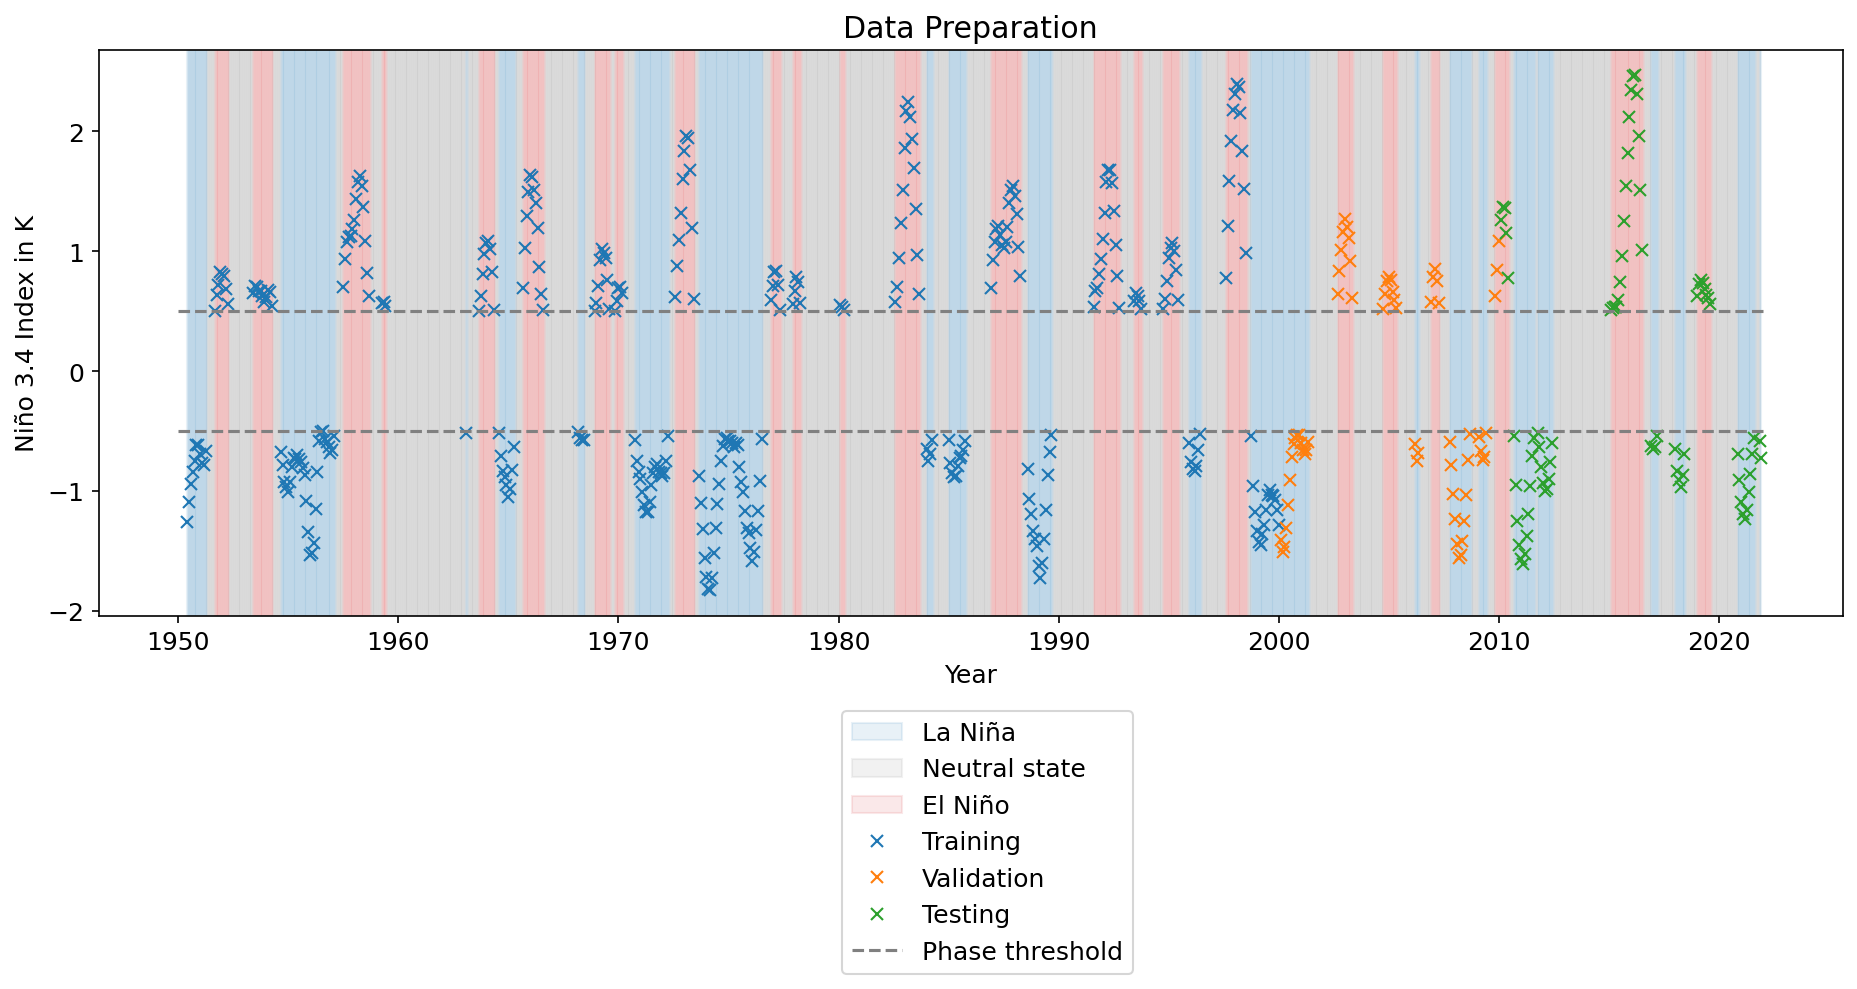

In [79]:
# Mark El Nino events in red and La Nina events in blue
el_nino_mask = nino34 > 0.5
la_nina_mask = nino34 < -0.5
no_event_mask = ~el_nino_mask & ~la_nina_mask

first_nino = True
first_nina = True
first_no_event = True
shade = 0.1

plt.figure(figsize=(15,5))

for i in range(len(timevec)-1):
    if el_nino_mask[i]:
        if first_nino:
            plt.axvspan(timevec[i], timevec[i+1], color='tab:red', alpha=shade, label="El Niño")
            first_nino = False
        else:
            plt.axvspan(timevec[i], timevec[i+1], color='tab:red', alpha=shade)
    elif la_nina_mask[i]:
        if first_nina:
            plt.axvspan(timevec[i], timevec[i+1], color='tab:blue', alpha=shade, label="La Niña")
            first_nina = False
        else:
            plt.axvspan(timevec[i], timevec[i+1], color='tab:blue', alpha=shade)
    else:
        if first_no_event:
            plt.axvspan(timevec[i], timevec[i+1], color='tab:gray', alpha=shade, label="Neutral state")
            first_no_event = False
        else:
            plt.axvspan(timevec[i], timevec[i+1], color='tab:gray', alpha=shade)

# Make a plot of the NINO3.4 data of the El Nino and La Nina events and show the different date sets in different colors
plt.plot(timevec_train, nino34_train, "x", label='Training')
plt.plot(timevec_val, nino34_val, "x", label='Validation')
plt.plot(timevec_test, nino34_test, "x", label='Testing')
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey', label="Phase threshold")
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.ylabel("Niño 3.4 Index in K")
plt.xlabel("Year")
plt.title("Data Preparation")
plt.legend(loc="center right", bbox_to_anchor=(0.6, -0.4))
plt.show()

## c)
#### Define a feedforward neural network (FNN) architecture with h hidden layers with nh neurons, with a learning rate η, with an activation function A, a loss function J, ridge regularisation with parameter β, the number of epochs n and a batch size b. The number of output nodes is nO = 2 (two classes). Use initially: h = 12, nh = 12, η = 10−3, A = ‘Relu’, J = ‘Cross Entropy’, β = 10−5 , n = 20 and b = 32.

Below, the FNN is defined as a class using pytorch. Also, the hyperparameters are set as given and lastly the data is flattened for later use.

In [80]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

# Define the FNN architecture
class FNN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, n_neurons_h, A):
        super(FNN, self).__init__()
        self.hidden_layers = nn.ModuleList() # empty nn.ModuleList to store hidden layers
        self.hidden_layers.append(nn.Linear(input_size, n_neurons_h)) # create first hidden layer
        for i in range(n_hidden-1):
            self.hidden_layers.append(nn.Linear(n_neurons_h, n_neurons_h)) # create the rest of the hidden layers
        self.output_layer = nn.Linear(n_neurons_h, output_size) # create output layer
        self.activation = A

    def forward(self, x):
        '''
        input tensor x is used to perform forward pass through the FNN to create output tensor
        '''
        for layer in self.hidden_layers:
            x = self.activation(layer(x)) # go through all hidden layers and create input for next hiddenlayer
        x = self.output_layer(x) # produce output tensor # uses softmax for 2 outputs, sigmoid for 1 output
        return x


In [81]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
n_hidden = 2
n_neurons_h = 12
n_out = 2
eta = 1e-3
f_activation = nn.ReLU()
f_loss = nn.CrossEntropyLoss()
beta = 1e-5
n_epochs = 20
batch_size = 32

In [82]:
# flattening SST map for input in FNN
sst_train_standardized_flattened = sst_train_standardized.reshape(sst_train_standardized.shape[0], -1)
sst_val_standardized_flattened = sst_val_standardized.reshape(sst_val_standardized.shape[0], -1)
sst_test_standardized_flattened = sst_test_standardized.reshape(sst_test_standardized.shape[0], -1)

## d)
#### Train the FNN on the training data set (using e.g. the Adam optimizer) and study the behaviour of the loss function for both training and validation data. For the standard values of the hyper-parameters, how many epochs are needed to obtain a training error of 5%? What is validation accuracy in this case?

To train the FNN, the data has to be transfered to a loader which is done first. Then, a function that trains the model is defined that can also calculate the loss for training and validation data as well as the accuracy for each epoch. This is then used to train the FNN and get the graph below which shows these measures as function of the epochs. In fact, the model is trained multiple times and the results are averaged to get a better picture of the general performance of the FNN structure. A training error of 5%, which is indicated by the gray dashed line, is already (barely) passed after the first epoch and yields an accuracy of 100% for the validation data. Further epochs only marginally reduce the loss function.

In [83]:
# Load training data into PyTorch DataLoader
train_data = TensorDataset(torch.Tensor(sst_train_standardized_flattened), torch.Tensor(classes_train))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Load validation data into PyTorch DataLoader
val_data = TensorDataset(torch.Tensor(sst_val_standardized_flattened), torch.Tensor(classes_val))
val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=True)

# Load test data into PyTorch DataLoader
test_data = TensorDataset(torch.Tensor(sst_test_standardized_flattened), torch.Tensor(classes_test))
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [84]:
def get_loss(model, loader, criterion, accuracy=False):
    model.eval()
    with torch.no_grad():
        loss_epoch = 0
        correct = 0
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss_epoch += loss.item()
            if accuracy:
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        tot_loss = loss_epoch / len(loader)
        tot_accuracy = correct / len(loader.dataset)
    
    if accuracy:
        returndict = {"loss": tot_loss, "accuracy": tot_accuracy}
    else:
        returndict = {"loss": tot_loss}
    return returndict

def train_fnn(model, train_loader, val_loader, criterion, optimizer, n_epochs, evaluate=True):
    # Initialize lists to store the loss function for both training and validation data and validation accuracy 
    train_loss = []
    val_loss = []
    val_acc = []
    
    # Loop over the specified number of epochs
    for epoch in range(n_epochs):

        if evaluate:
            # evaluate model performance
            train_dict = get_loss(model, train_loader, criterion, accuracy=False)
            val_dict = get_loss(model, val_loader, criterion, accuracy=True)

            val_loss.append(val_dict["loss"])
            val_acc.append(val_dict["accuracy"])
            train_loss.append(train_dict["loss"])

        # train model 
        model.train() 
        # Loop over the training data in batches
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad() # Zero the gradients
            outputs = model(inputs) # Forward pass through the model
            loss = criterion(outputs, labels.long()) # Compute the loss
            loss.backward() # Backward pass through the model
            optimizer.step() # Update the weights
    
    return train_loss, val_loss, val_acc

In [104]:
n_trains = 5
train_losses = []
val_losses = []
val_acces = []

for i in range(n_trains):
    # Define FNN architecture
    model = FNN(input_size=int(sst_train_standardized_flattened.shape[1]), output_size=n_out, n_hidden=n_hidden, n_neurons_h=n_neurons_h, A=f_activation)
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=eta)

    # Train FNN using the training data and optimizer
    train_loss, val_loss, val_acc = train_fnn(model=model, train_loader=train_loader, val_loader=val_loader, criterion=f_loss, optimizer=optimizer, n_epochs=n_epochs)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_acces.append(val_acc)

# get mean of all runs
train_loss, val_loss, val_acc = np.mean(train_losses, axis=0), np.mean(val_losses, axis=0), np.mean(val_acces, axis=0)

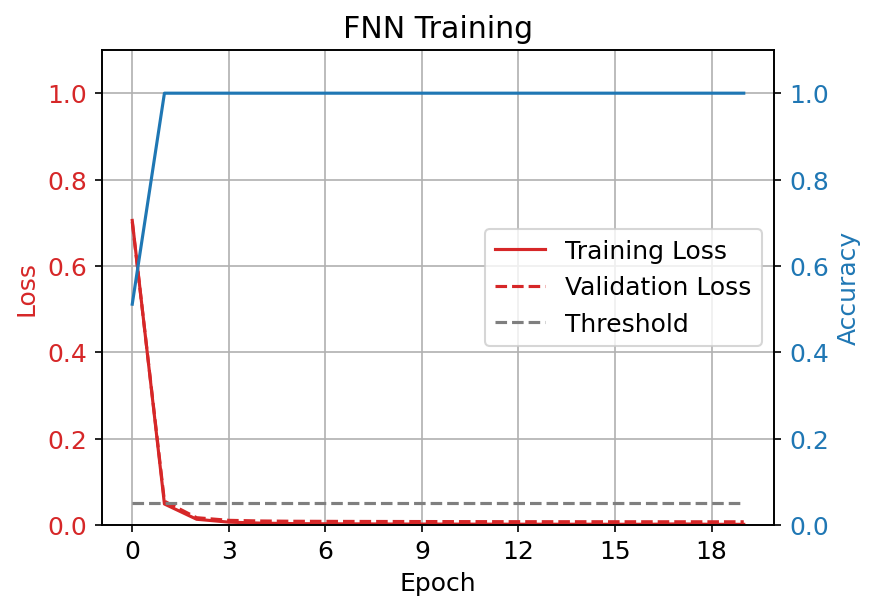

In [105]:
x_epochs = np.arange(0, n_epochs)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(x_epochs, train_loss, label="Training Loss", color=color)
ax1.plot(x_epochs, val_loss, label="Validation Loss", linestyle='--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(x_epochs, val_acc, label="Validation Accuracy", color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the maximum number of x-axis ticks
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Set the y-axis limits for both axes
ax1.set_ylim([0.0, 1.1])
ax2.set_ylim([0.0, 1.1])

# Add grid to both axes
ax1.grid(True)

ax1.hlines(0.05, x_epochs[0], x_epochs[-1], color="tab:gray", ls="dashed", label="Threshold")



fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc="center right")
ax1.set_title("FNN Training")
plt.show()


## e)
#### What is the effect of the learning rate on the training error?

To study the influence of the learning rate on the training error, different learning rates are tested and the training error is assessed after 20 epochs. As in the homework, to improve the reliability of the results, the model has been trained 3 times for each learning rate and the results have been averaged. The result is plotted in the graph below. It can be seen that the initial learning rate of $\eta = 10^{-3}$ is found in the minimum of the curve. Other, somewhat larger learning rates would also yield a comparable performance of the FNN. As in the homework, for too small or too large learning rates, the training error increases. Those would thus not be a good choice for this hyperparameter. 


In [87]:
learning_rates = [0.5]
for i in range(1, 15):
    learning_rates.append(learning_rates[i-1]/2)

def learning_rate_test(learning_rates, activation_f, n_runs=3):
    loss_values = []

    # loop through different learning rates
    for lr in learning_rates:
        loss_sum = 0
        
        # train the model multiple times to avoid coincidental results
        for run in range(n_runs):
            model = FNN(input_size=int(sst_train_standardized_flattened.shape[1]), output_size=n_out, n_hidden=n_hidden, n_neurons_h=n_neurons_h, A=activation_f)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            train_fnn(model=model, train_loader=train_loader, val_loader=val_loader, criterion=f_loss, optimizer=optimizer, n_epochs=n_epochs, evaluate=False)
            loss_dict = get_loss(model, loader=train_loader, criterion=f_loss, accuracy=False)
            loss = loss_dict["loss"]
            loss_sum += loss

        loss_avg = loss_sum / n_runs
        loss_values.append(loss_avg)

    return loss_values

loss_values = learning_rate_test(learning_rates, f_activation)

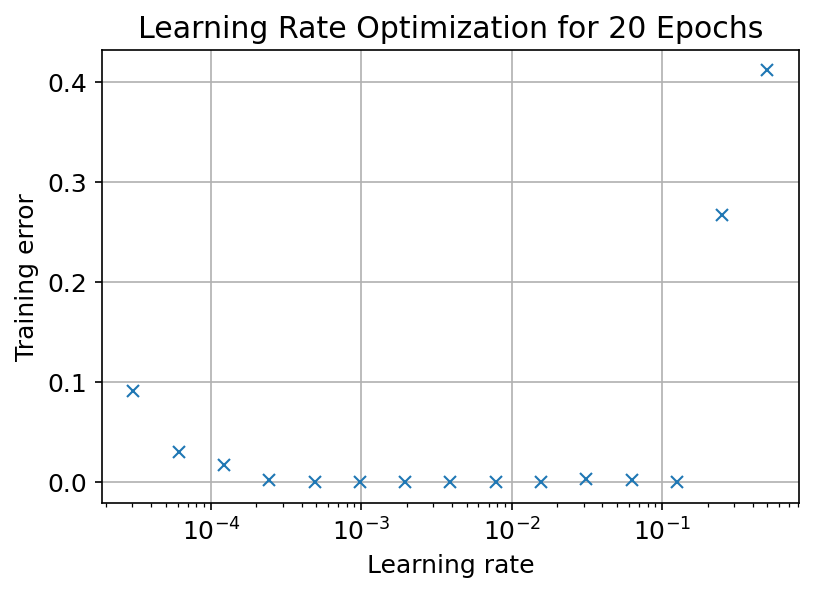

In [88]:
plt.plot(learning_rates, loss_values, "x")
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Training error')
plt.grid(True)
plt.title("Learning Rate Optimization for 20 Epochs")
plt.show()

## f)
#### Study the effect of the activation function (apart from ’Relu’, choose ’Sigmoid’ or ’Softmax’) on the training and validation results. Which one gives more accurate results for the same number of epochs

To compare the influence of the activation function on the FNN performance, the FNN is trained with three different activation functions: ReLU (as before), Sigmoid and Softmax. The Sigmoid function maps the outcome between 0 and 1 and can therefore be interpreted as a probability. The softmax is typically used as the activation function at the output of the network as it transforms the output nodes to a probability vector whose entries sum up to one.

During the training, the training and validation error as well as the validation accuracy is logged. All FNN were first trained with standard settings as before and the result can be seen in the figure below. It is evident that the FNN with ReLU as the activation function performs the best as it learns the fastest, i.e. minimizes the loss function after only a few epochs. The other activation functions perform significantly worse and reduce the loss function much slower. While the Sigmoid is considerably faster than the Softmax, both seem to converge. Ultimately, all activation function enable the FNN to have almost 100% accuracy after 20 epochs. 
It has to be noted, however, that this comparison is not quite fair. This is because hyperparameters and particularly the learning rate were used that are near optimal for the FNN with ReLU. A way to improve the fairness of the comparison is described and performed below the graph.

In [89]:
n_trains = 5
f_activation_ls = [nn.ReLU(), nn.Sigmoid(), nn.Softmax()]
f_activation_ls_str = ["ReLU", "Sigmoid", "Softmax"]
train_losses = []
val_losses = []
val_accs = []

for f in f_activation_ls:
    train_losses_all = []
    val_losses_all = []
    val_accs_all = []
    
    # train network multiple times to get average performance
    for i in range(n_trains):
        model = FNN(input_size=int(sst_train_standardized_flattened.shape[1]), output_size=n_out, n_hidden=n_hidden, n_neurons_h=n_neurons_h, A=f)
        optimizer = optim.Adam(model.parameters(), lr=eta)
        train_loss, val_loss, val_acc = train_fnn(model=model, train_loader=train_loader, val_loader=val_loader, criterion=f_loss, optimizer=optimizer, n_epochs=n_epochs)
        train_losses_all.append(train_loss)
        val_losses_all.append(val_loss)
        val_accs_all.append(val_acc)
    
    train_loss, val_loss, val_acc = np.mean(train_losses_all, axis=0), np.mean(val_losses_all, axis=0), np.mean(val_accs_all, axis=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

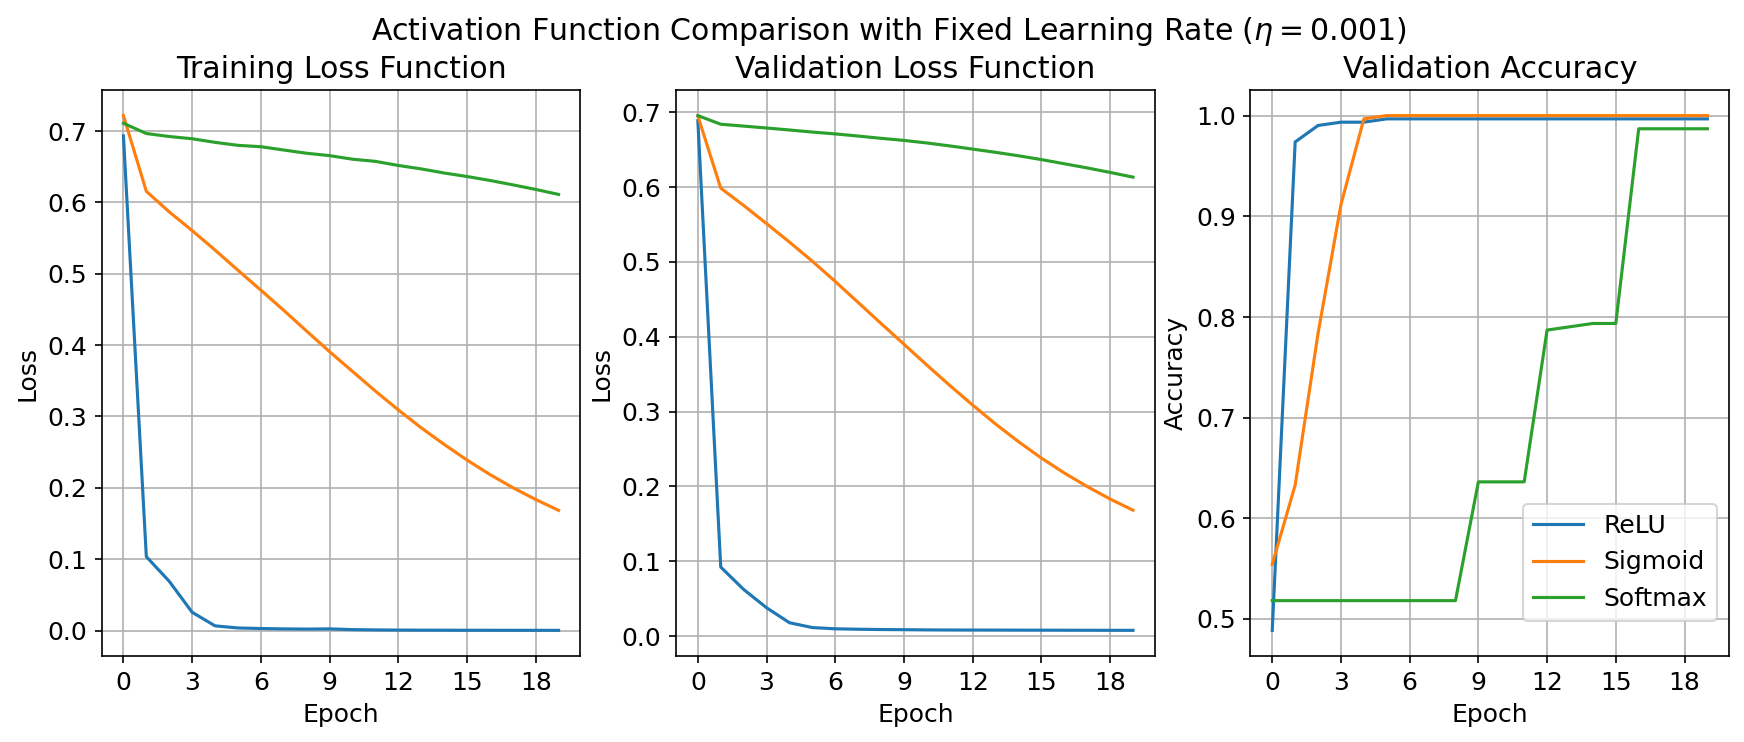

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
for idx, (train_loss, val_loss, val_acc) in enumerate(zip(train_losses, val_losses, val_accs)):
    axs[0].plot(x_epochs, train_loss)
    axs[1].plot(x_epochs, val_loss)
    axs[2].plot(x_epochs, val_acc)
    
axs[0].set_title(f'Training Loss Function')
axs[0].set_ylabel('Loss')
axs[1].set_title(f'Validation Loss Function')
axs[1].set_ylabel('Loss')
axs[2].set_title(f'Validation Accuracy')
axs[2].set_ylabel('Accuracy')


for ax in axs:
    ax.set_xlabel('Epoch')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True)

lines = axs[0].get_lines()
handles = [lines[i] for i, _ in enumerate(f_activation_ls_str)]

fig.suptitle(f'Activation Function Comparison with Fixed Learning Rate ($\eta = {eta}$)')
fig.legend(handles=handles, labels=f_activation_ls_str, loc='center right', bbox_to_anchor=(0.9, 0.25));


To improve the meaningfulness of the comparison, the hyperparameter $\eta$ is optimized for each FNN with different activation functions. This is a way to allow each FNN to be trained more closely to their full potential. However, note that other hyperparameters were still not optimized and can therefore induce bias. After an optimal learning rate is found, each model is trained and the same plot as before is generated. As a result, it can be seen that the training and validation loss decreases much faster than before and the validation accuracy reaches its maximum at a much earlier epoch. Using the sigmoid activation function turns out to be almost as efficient as the ReLU in terms of training and validation error, while the Softmax FNN still laggs behind and converges much slower and less low.

To summarize, the ReLU activation function would be the optimal choice in this case as it reduces the training error the quickest. The other activation functions are, however, fundamentally also capable of mostly accurate clasification, albeit with slower convergence. At the same time, it has to be acknowledged that another choice of the remaining hyperparameters other than learning rate might be more favorable for the Sigmoid and SoftMax configurations. Due to the simplicity of the ReLU activation function it is also important to consider that its derivative is faster to compute which makes the training of the network less expensive.

In [91]:
eta_opts = []
train_losses = []
val_losses = []
val_accs = []

for idx, f in enumerate(f_activation_ls):
    train_losses_all = []
    val_losses_all = []
    val_accs_all = []

    # get optimized learning rate
    if not idx:
        eta_opt = eta
    else:
        lossvals = learning_rate_test(learning_rates, f, n_runs=3)
        eta_opt = learning_rates[np.argmin(lossvals)]
    eta_opts.append(eta_opt)

    for i in range(n_trains):
        model = FNN(input_size=int(sst_train_standardized_flattened.shape[1]), output_size=n_out, n_hidden=n_hidden, n_neurons_h=n_neurons_h, A=f)
        optimizer = optim.Adam(model.parameters(), lr=eta_opt)
        train_loss, val_loss, val_acc = train_fnn(model=model, train_loader=train_loader, val_loader=val_loader, criterion=f_loss, optimizer=optimizer, n_epochs=n_epochs)
        train_losses_all.append(train_loss)
        val_losses_all.append(val_loss)
        val_accs_all.append(val_acc)
    
    train_loss, val_loss, val_acc = np.mean(train_losses_all, axis=0), np.mean(val_losses_all, axis=0), np.mean(val_accs_all, axis=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

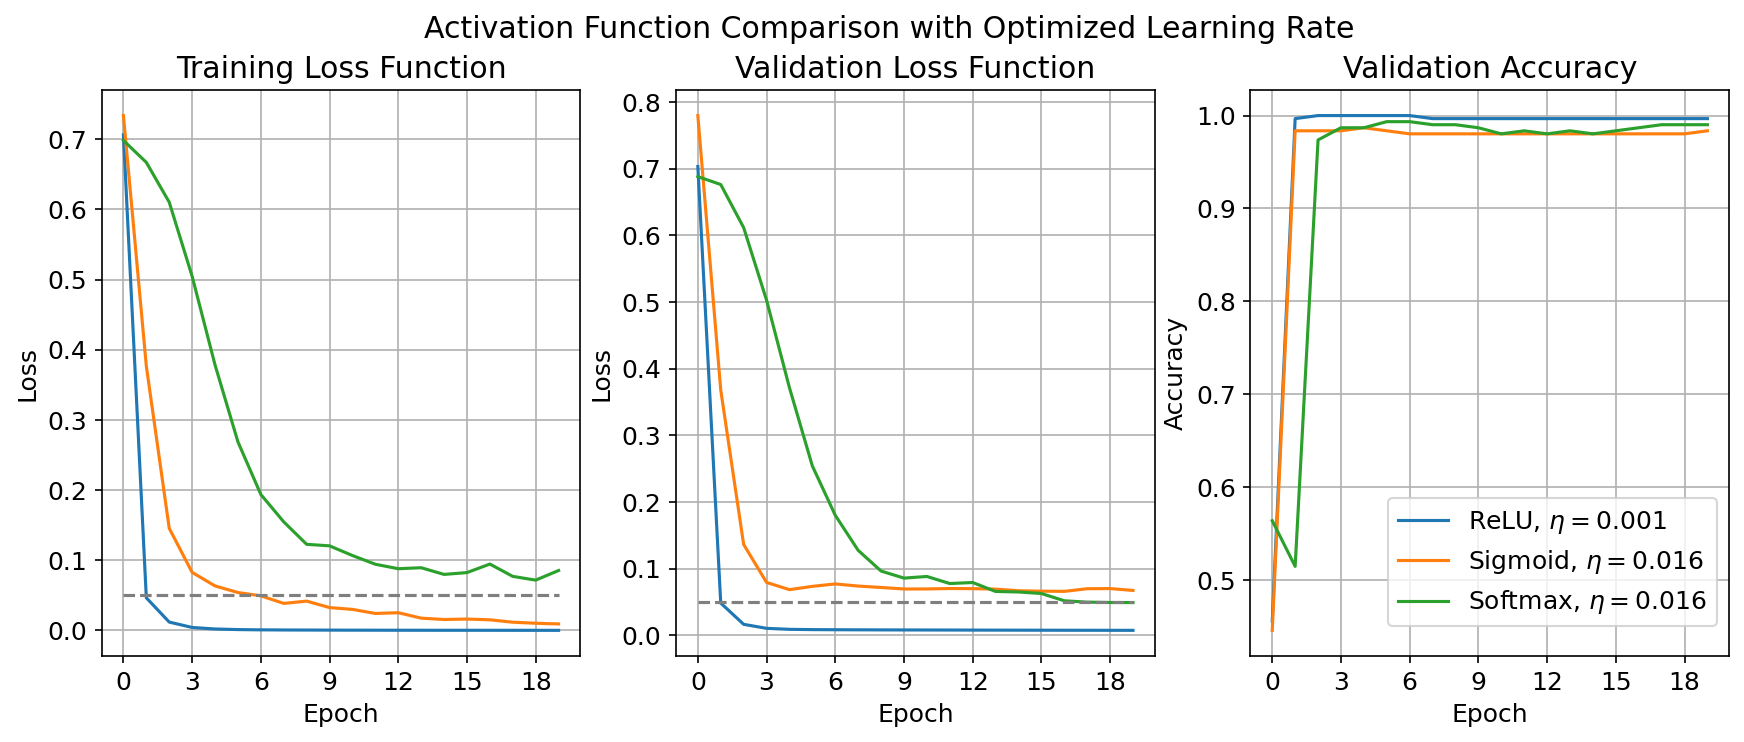

In [92]:
legend = [f"ReLU, $\eta = {round(eta, 3)}$", f"Sigmoid, $\eta = {round(eta_opts[1], 3)}$", f"Softmax, $\eta = {round(eta_opts[2], 3)}$"]

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
for idx, (train_loss, val_loss, val_acc) in enumerate(zip(train_losses, val_losses, val_accs)):
    axs[0].plot(x_epochs, train_loss)
    axs[1].plot(x_epochs, val_loss)
    axs[2].plot(x_epochs, val_acc)
    
axs[0].set_title(f'Training Loss Function')
axs[0].set_ylabel('Loss')
axs[1].set_title(f'Validation Loss Function')
axs[1].set_ylabel('Loss')
axs[2].set_title(f'Validation Accuracy')
axs[2].set_ylabel('Accuracy')

axs[0].hlines(0.05, x_epochs[0], x_epochs[-1], color="tab:gray", ls="dashed")
axs[1].hlines(0.05, x_epochs[0], x_epochs[-1], color="tab:gray", ls="dashed")

for ax in axs:
    ax.set_xlabel('Epoch')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True)

lines = axs[0].get_lines()
handles = [lines[i] for i, _ in enumerate(legend)]

fig.suptitle(f'Activation Function Comparison with Optimized Learning Rate')
fig.legend(handles=handles, labels=legend, loc='center right', bbox_to_anchor=(0.9, 0.25));

## g)
#### Now evaluate the model for the SST test data set and determine model accuracy in correctly classifying El Niño and La Niña. Plot also the so-called confusion matrix, showing the number of the predicted events (false/true) versus the true events.

Finally, the test data is being used to evaluate the model. As the occurence of El Nino and El Nina is in the same order of magnitude, accuracy is a good measure to quantify the perfromance of the model. The accuracy is found at the bottom of the confusion matrix. The confusion matrix gives more insight into the perfomance of the model and shows that the only incorrectly classified signals where La Nina phases that were classified as El Nino.

In [108]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
n_hidden = 2
n_neurons_h = 12
n_out = 2
eta = 1e-3
f_activation = nn.ReLU()
f_loss = nn.CrossEntropyLoss()
beta = 1e-5
n_epochs = 20
batch_size = 32

In [109]:
# Define FNN architecture
model = FNN(input_size=int(sst_train_standardized_flattened.shape[1]), output_size=n_out, n_hidden=n_hidden, n_neurons_h=n_neurons_h, A=f_activation)
# Define optimizer

optimizer = optim.Adam(model.parameters(), lr=eta)

# Train FNN using the training data and optimizer
train_loss, val_loss, val_acc = train_fnn(model=model, train_loader=train_loader, val_loader=val_loader, criterion=f_loss, optimizer=optimizer, n_epochs=n_epochs)

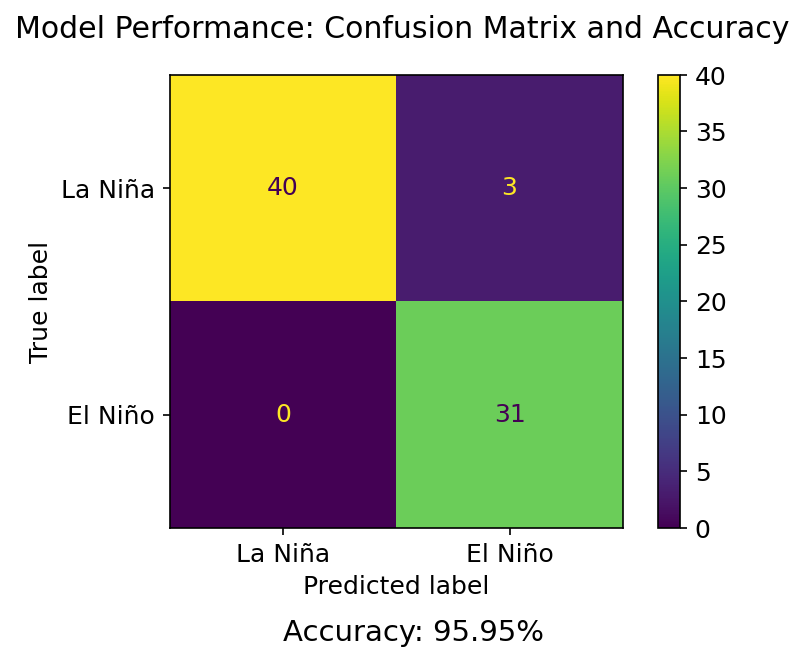

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for x, y in test_loader:
    test_data = x
    test_targets = y
    break

# evaluate on test set
test_outputs = model(test_data)
_, test_outputs = torch.max(test_outputs.data, 1)

# calculate confusion matrix
cm = confusion_matrix(test_targets, test_outputs)
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['La Niña', 'El Niño'])
disp.plot()
plt.suptitle("Model Performance: Confusion Matrix and Accuracy")
plt.text(0, 2, f"Accuracy: {accuracy*100:.2f}%", fontsize=14);

## h)
#### Finally, make composite plots of the global SST for El Niño events and global SST for La Niña events.

As inferable from the confusion matrix, we do not have a situation where the FNN predicts a La Nina when there is actually an El Nino. Therefore, no composite plot can be created for that example and 3 plots remain. The first two figures below show the average SST anomaly world-wide that lead the neural network to predict a La Nina and an El Nino correctly. Here, the typical features of SST during the different phases of ENSO are visible. Most pronounced, is the SST anomaly of the equatorial central pacific which is highly elevated when the NN correctly predicts El Nino and very negative for La Nina. The SST anomaly can also be seen to be negative for El Nino and positive for La Nina around the western equatorial pacific. Many other teleconnections of ENSO are known which could possibly be identified in the composite plots.

For the incorrectly predicted phases (El Nino was predicted when it was in fact a La Nina), it has to be admitted that the composite map does not have as much pronounced features which makes it hard for the NN to predict correctly. The colder SST around Nino 3.4 region is not as significant as during strong La Ninas. Additionally, the west coast of South America is unusually warm. Presumably these events where thus events of weak and short La Ninas. This could be analyzed in more detail by looking at the individual events, their time of occurence and corresponding ONI index.

In [111]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

In [112]:
lats = np.linspace(-90, 90, 89)
lons = np.linspace(0, 360, 180)

tn_idx = np.where((test_targets == 0) & (test_outputs == 0))[0] # True Negatives indices = true La Nina
fp_idx = np.where((test_targets == 0) & (test_outputs == 1))[0] # False Positives indices = wrong Nino
fn_idx = np.where((test_targets == 1) & (test_outputs == 0))[0] # False Negatives indices = wrong Nina
tp_idx = np.where((test_targets == 1) & (test_outputs == 1))[0] # True Positives indices = true El Nino

In [113]:
lat = sstds.coords["lat"]
lon = sstds.coords["lon"]
coordinates = [lat, lon]
sst_true_nina = xr.DataArray(np.mean(sst_test[tn_idx], axis=0), coords=coordinates)
sst_true_nino = xr.DataArray(np.mean(sst_test[tp_idx], axis=0), coords=coordinates)
sst_false_nino = xr.DataArray(np.mean(sst_test[fp_idx], axis=0), coords=coordinates)

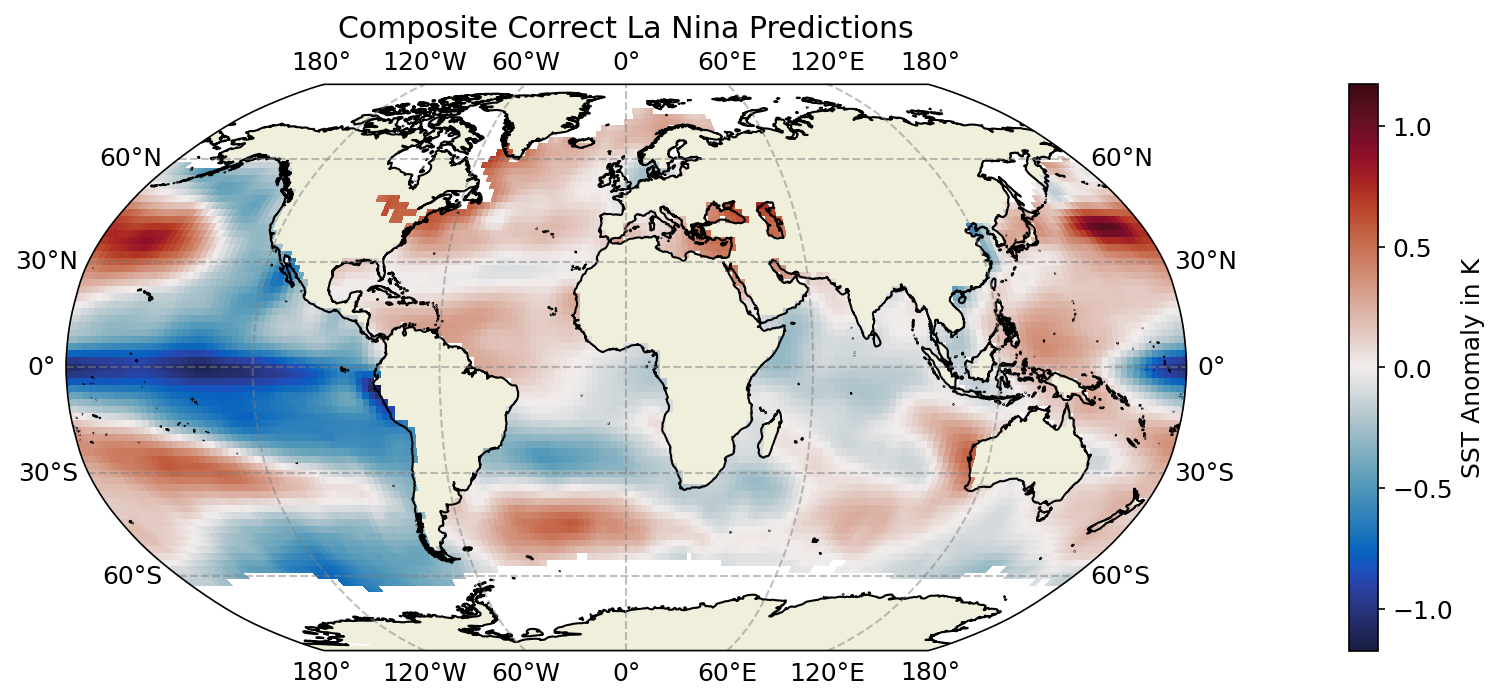

In [114]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
im = sst_true_nina.plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, add_colorbar=False)
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1, label="SST Anomaly in K")
plt.title("Composite Correct La Nina Predictions");

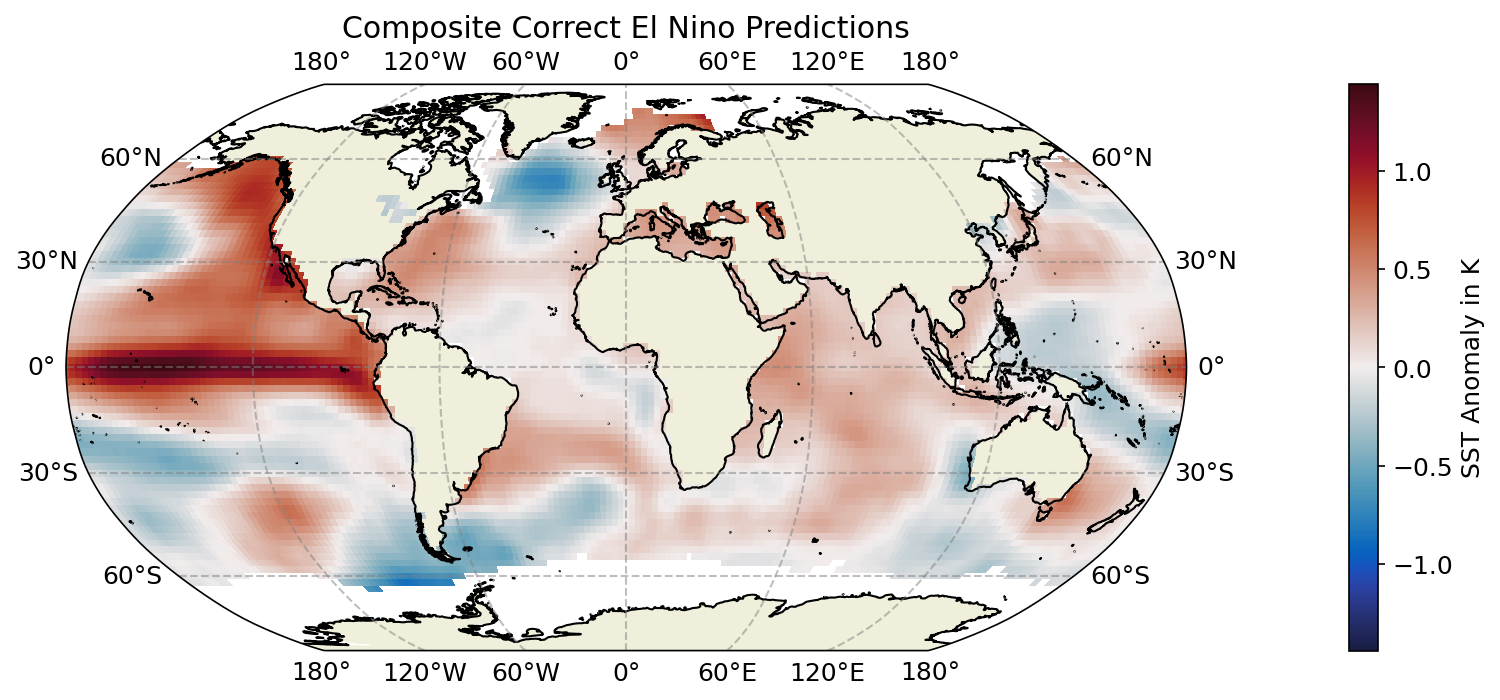

In [115]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
im = sst_true_nino.plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, add_colorbar=False)
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1, label="SST Anomaly in K")
plt.title("Composite Correct El Nino Predictions");

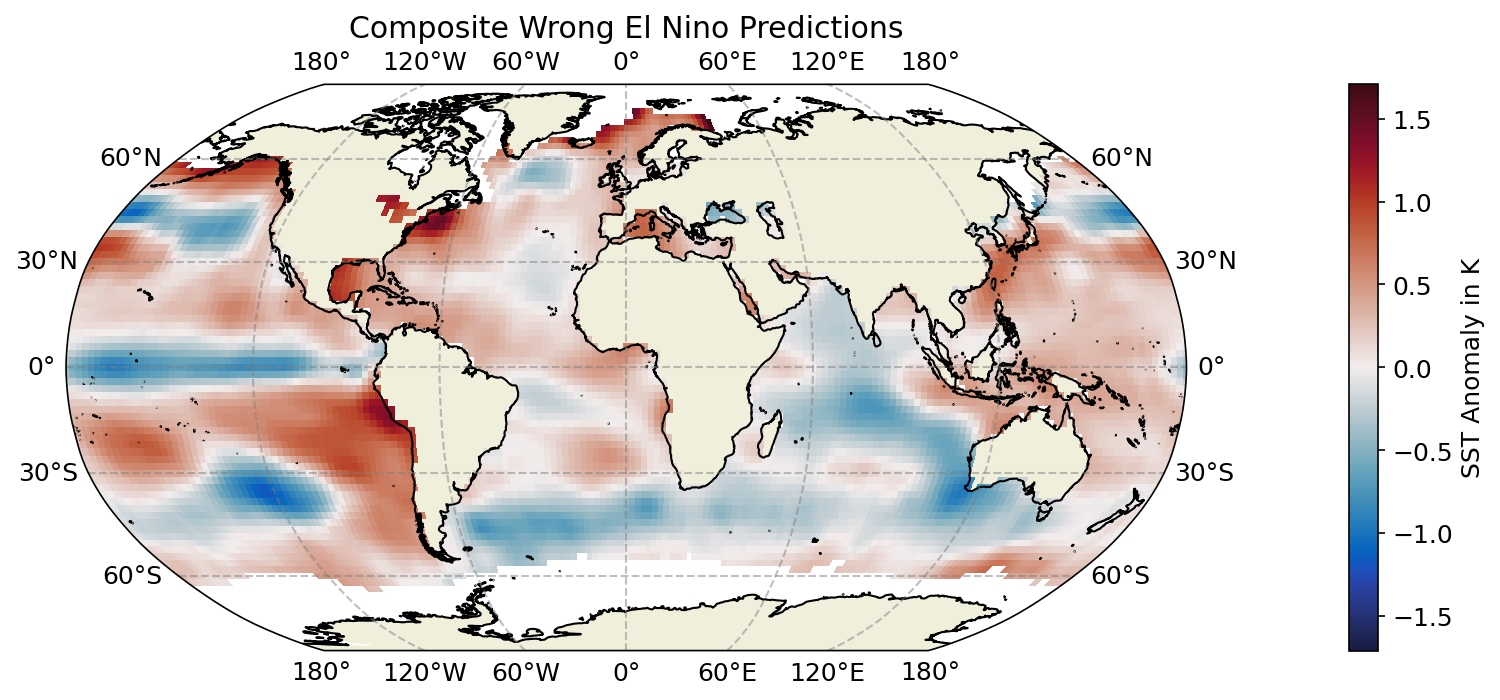

In [116]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0))
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
im = sst_false_nino.plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, add_colorbar=False)
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1, label="SST Anomaly in K")
plt.title("Composite Wrong El Nino Predictions");